# Silkworm feeding prediction




## Check GPU

In [ ]:
import torch, subprocess, json, sys

# Test via PyTorch
if torch.cuda.is_available():
    print("PyTorch détecte un GPU :", torch.cuda.get_device_name(0))
else:
    print("PyTorch ne détecte pas de GPU.")

# Test via nvidia-smi (avec gestion d’erreur)
try:
    gpu_info = subprocess.check_output(["nvidia-smi", "-L"]).decode().strip()
    print("nvidia-smi répond :", gpu_info)
except FileNotFoundError:
    print("nvidia-smi absent : probablement pas de GPU ou runtime CPU.")
except subprocess.CalledProcessError as e:
    print("nvidia-smi existe mais renvoie une erreur :", e.output.decode())


PyTorch détecte un GPU : NVIDIA L4
nvidia-smi répond : GPU 0: NVIDIA L4 (UUID: GPU-7133a1e5-2693-e2d0-0e1d-ea25c86964fb)


# Dataset import and exploration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/Copie de silk_dataset.zip"
print(zip_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Copie de silk_dataset.zip


In [ ]:
# 1 min d'extraction de fichier

import zipfile
import os


# Check if zip file exists
if os.path.exists(zip_path):
    print(f"Zip file found at: {zip_path}")

    # Extract the zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content/extracted_data')

    # Explore the extracted contents
    extracted_path = '/content/extracted_data'
    for root, dirs, files in os.walk(extracted_path):
        level = root.replace(extracted_path, '').count(os.sep)
        indent = ' ' * 2 * level
        # print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 2 * (level + 1)
        for file in files:
            print(f'{subindent}{file}')
else:
    print(f"Zip file not found at: {zip_path}")
    print("Available files in MyDrive:")
    for file in os.listdir("/content/drive/MyDrive/"):
        if file.endswith('.zip'):
            print(f"  {file}")

Zip file found at: /content/drive/MyDrive/Copie de silk_dataset.zip
    IMG_2800.jpg
    IMG_3997.jpg
    IMG_3692.jpg
    IMG_3876.jpg
    IMG_3461.jpg
    IMG_3325.jpg
    IMG_2751.jpg
    IMG_2903.jpg
    IMG_3756.jpg
    IMG_3335.jpg
    IMG_3708.jpg
    IMG_3722.jpg
    IMG_3749.jpg
    IMG_2748.jpg
    IMG_2815.jpg
    IMG_3947.jpg
    IMG_3806.jpg
    IMG_2981.jpg
    IMG_3996.jpg
    IMG_3602.jpg
    IMG_3179.jpg
    IMG_3547.jpg
    IMG_3605.jpg
    IMG_3289.jpg
    IMG_3286.jpg
    IMG_3499.jpg
    IMG_3481.jpg
    IMG_3096.jpg
    IMG_3587.jpg
    IMG_3471.jpg
    IMG_2789.jpg
    IMG_3881.jpg
    IMG_2909.jpg
    IMG_3171.jpg
    IMG_3574.jpg
    IMG_2859.jpg
    IMG_3808.jpg
    IMG_3732.jpg
    IMG_3391.jpg
    IMG_3190.jpg
    IMG_3964.jpg
    IMG_2692.jpg
    IMG_3536.jpg
    IMG_3506.jpg
    IMG_2874.jpg
    IMG_3366.jpg
    IMG_3800.jpg
    IMG_3971.jpg
    IMG_3488.jpg
    IMG_3287.jpg
    IMG_2758.jpg
    IMG_3204.jpg
    IMG_3561.jpg
    IMG_3023.jpg
    IMG_3630.j

In [ ]:
import pandas as pd
import numpy as np
import os
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Analyser le contenu extrait
print("📊 Analyse du dataset extrait:")
extracted_path = '/content/extracted_data'

# Trouver le fichier CSV
csv_files = []
image_dirs = []

for root, dirs, files in os.walk(extracted_path):
    for file in files:
        if file.endswith('.csv'):
            csv_files.append(os.path.join(root, file))
        elif file.endswith(('.jpg', '.jpeg', '.png')):
            if root not in image_dirs:
                image_dirs.append(root)

print(f"📋 Fichiers CSV trouvés: {len(csv_files)}")
for csv_file in csv_files:
    print(f"  - {csv_file}")

print(f"📁 Dossiers avec images trouvés: {len(image_dirs)}")
for img_dir in image_dirs:
    img_count = len([f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
    print(f"  - {img_dir} ({img_count} images)")

# 2. Charger et analyser le CSV
if csv_files:
    main_csv = csv_files[0]  # Prendre le premier CSV trouvé
    print(f"\n📊 Chargement du fichier: {os.path.basename(main_csv)}")

    df = pd.read_csv(main_csv)
    print(f"✅ Dataset chargé: {df.shape[0]} lignes, {df.shape[1]} colonnes")

    print("\n📋 Aperçu du dataset:")
    print(df.head())

    print("\n📊 Informations sur les colonnes:")
    print(df.info())

    print("\n📈 Colonnes disponibles:")
    for i, col in enumerate(df.columns):
        print(f"  {i+1}. {col}")
else:
    print("❌ Aucun fichier CSV trouvé!")

📊 Analyse du dataset extrait:
📋 Fichiers CSV trouvés: 1
  - /content/extracted_data/silk_dataset/0_data.csv
📁 Dossiers avec images trouvés: 1
  - /content/extracted_data/silk_dataset (1351 images)

📊 Chargement du fichier: 0_data.csv
✅ Dataset chargé: 1351 lignes, 2 colonnes

📋 Aperçu du dataset:
   classificazione          foto
0                0  IMG_2663.jpg
1                0  IMG_2664.jpg
2                0  IMG_2665.jpg
3                0  IMG_2666.jpg
4                0  IMG_2667.jpg

📊 Informations sur les colonnes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1351 entries, 0 to 1350
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   classificazione  1351 non-null   int64 
 1   foto             1351 non-null   object
dtypes: int64(1), object(1)
memory usage: 21.2+ KB
None

📈 Colonnes disponibles:
  1. classificazione
  2. foto



🔍 Identification automatique des colonnes:
🏷️ Colonne label détectée: 'classificazione'
📄 Colonne nom de fichier détectée: 'foto'

✅ Configuration détectée:
  - Images: colonne 'foto'
  - Labels: colonne 'classificazione'

📊 Distribution des labels:
classificazione
0    595
1    756
Name: count, dtype: int64

📈 Pourcentages:
  Label 0: 44.0%
  Label 1: 56.0%
✅ Dataset relativement équilibré.


/tmp/ipython-input-5-2359086183.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if df[col].astype(str).str.contains(r'\.(jpg|jpeg|png|JPEG|JPG|PNG)', na=False).any():
/tmp/ipython-input-5-2359086183.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if df[col].astype(str).str.contains(r'\.(jpg|jpeg|png|JPEG|JPG|PNG)', na=False).any():


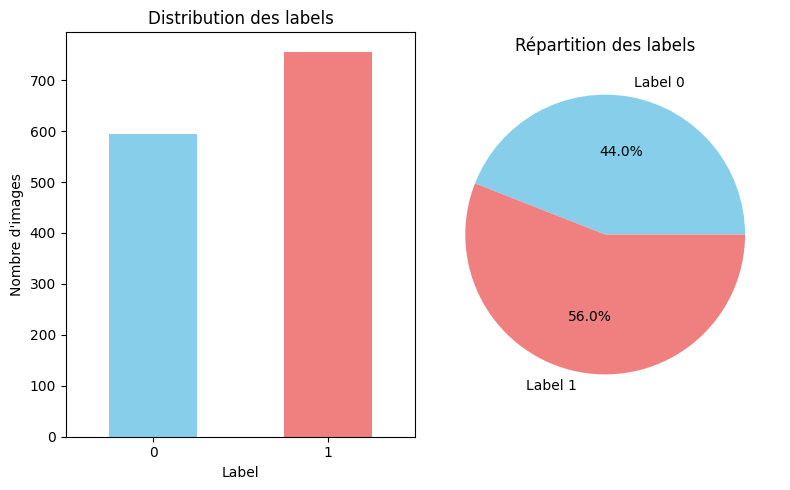

In [ ]:
# 3. Identifier automatiquement les colonnes importantes
if csv_files and not df.empty:
    print("\n🔍 Identification automatique des colonnes:")

    # Trouver la colonne avec les noms de fichiers
    filename_col = None
    label_col = None

    for col in df.columns:
        # Colonne filename: contient probablement des extensions d'image
        if df[col].astype(str).str.contains(r'\.(jpg|jpeg|png|JPEG|JPG|PNG)', na=False).any():
            filename_col = col
            print(f"📄 Colonne nom de fichier détectée: '{col}'")

        # Colonne label: contient uniquement 0 et 1
        elif df[col].dtype in ['int64', 'float64'] and set(df[col].dropna().unique()).issubset({0, 1, 0.0, 1.0}):
            label_col = col
            print(f"🏷️ Colonne label détectée: '{col}'")

    if filename_col and label_col:
        print(f"\n✅ Configuration détectée:")
        print(f"  - Images: colonne '{filename_col}'")
        print(f"  - Labels: colonne '{label_col}'")

        # Analyser la distribution des labels
        print(f"\n📊 Distribution des labels:")
        label_counts = df[label_col].value_counts().sort_index()
        print(label_counts)

        # Calculer le pourcentage
        label_pct = df[label_col].value_counts(normalize=True).sort_index() * 100
        print(f"\n📈 Pourcentages:")
        for label, pct in label_pct.items():
            print(f"  Label {label}: {pct:.1f}%")

        # Vérifier l'équilibrage des classes
        if abs(label_pct.iloc[0] - label_pct.iloc[1]) > 20:
            print("⚠️  Dataset déséquilibré détecté! Considérez des techniques de rééquilibrage.")
        else:
            print("✅ Dataset relativement équilibré.")

        # Visualiser la distribution
        plt.figure(figsize=(8, 5))
        plt.subplot(1, 2, 1)
        label_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
        plt.title('Distribution des labels')
        plt.xlabel('Label')
        plt.ylabel('Nombre d\'images')
        plt.xticks(rotation=0)

        plt.subplot(1, 2, 2)
        plt.pie(label_counts.values, labels=[f'Label {i}' for i in label_counts.index],
                autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
        plt.title('Répartition des labels')

        plt.tight_layout()
        plt.show()

    else:
        print("❌ Impossible d'identifier automatiquement les colonnes.")
        print("💡 Veuillez spécifier manuellement les noms des colonnes.")
else:
    print("❌ Pas de données à analyser.")

In [ ]:
# 4. Vérifier l'existence des images et nettoyer le dataset
if filename_col and label_col:
    print("\n🔍 Vérification de l'existence des images:")

    # Trouver le dossier contenant les images
    main_image_dir = None
    for img_dir in image_dirs:
        img_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG'))]
        if len(img_files) > 0:
            main_image_dir = img_dir
            break

    if main_image_dir:
        print(f"📁 Dossier d'images principal: {main_image_dir}")

        # Vérifier quelles images existent réellement
        existing_images = []
        missing_images = []

        for idx, row in df.iterrows():
            filename = str(row[filename_col])
            image_path = os.path.join(main_image_dir, filename)

            if os.path.exists(image_path):
                existing_images.append(idx)
            else:
                missing_images.append((idx, filename))

        print(f"✅ Images existantes: {len(existing_images)}")
        print(f"❌ Images manquantes: {len(missing_images)}")

        if missing_images:
            print("📋 Premières images manquantes:")
            for i, (idx, filename) in enumerate(missing_images[:5]):
                print(f"  - {filename}")
            if len(missing_images) > 5:
                print(f"  ... et {len(missing_images) - 5} autres")

        # Filtrer le dataset pour ne garder que les images existantes
        if missing_images:
            df_clean = df.iloc[existing_images].copy()
            print(f"\n🧹 Dataset nettoyé: {df_clean.shape[0]} images valides")
        else:
            df_clean = df.copy()
            print(f"\n✅ Toutes les images sont présentes!")

        # Stocker les variables importantes pour la suite
        IMAGE_DIR = main_image_dir
        FILENAME_COL = filename_col
        LABEL_COL = label_col
        CLEAN_DF = df_clean

        print(f"\n📝 Variables configurées:")
        print(f"  - IMAGE_DIR = '{IMAGE_DIR}'")
        print(f"  - FILENAME_COL = '{FILENAME_COL}'")
        print(f"  - LABEL_COL = '{LABEL_COL}'")
        print(f"  - CLEAN_DF: {CLEAN_DF.shape[0]} lignes")

    else:
        print("❌ Aucun dossier d'images trouvé!")
else:
    print("❌ Impossible de continuer sans identifier les colonnes.")


🔍 Vérification de l'existence des images:
📁 Dossier d'images principal: /content/extracted_data/silk_dataset
✅ Images existantes: 1351
❌ Images manquantes: 0

✅ Toutes les images sont présentes!

📝 Variables configurées:
  - IMAGE_DIR = '/content/extracted_data/silk_dataset'
  - FILENAME_COL = 'foto'
  - LABEL_COL = 'classificazione'
  - CLEAN_DF: 1351 lignes


In [ ]:
# 5. OPTION 1: Créer une structure organisée par classes (recommandé pour deep learning)
def create_organized_structure():
    """Crée une structure train/val/test avec des dossiers par classe"""

    print("\n🏗️ Création d'une structure organisée par classes:")

    # Créer la structure de dossiers
    base_dir = '/content/organized_dataset'
    splits = ['train', 'val', 'test']
    classes = ['class_0', 'class_1']  # ou ['negative', 'positive'] selon votre préférence

    for split in splits:
        for cls in classes:
            os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

    # Mélanger et diviser le dataset
    from sklearn.model_selection import train_test_split

    # Division train/temp (80/20)
    train_df, temp_df = train_test_split(
        CLEAN_DF,
        test_size=0.2,
        stratify=CLEAN_DF[LABEL_COL],
        random_state=42
    )

    # Division temp en val/test (10/10 du total)
    val_df, test_df = train_test_split(
        temp_df,
        test_size=0.5,
        stratify=temp_df[LABEL_COL],
        random_state=42
    )

    print(f"📊 Division du dataset:")
    print(f"  - Train: {len(train_df)} images")
    print(f"  - Validation: {len(val_df)} images")
    print(f"  - Test: {len(test_df)} images")

    # Copier les images dans la nouvelle structure
    def copy_images_to_structure(df, split_name):
        print(f"\n📁 Copie des images {split_name}...")
        copied = 0

        for _, row in df.iterrows():
            filename = str(row[FILENAME_COL])
            label = int(row[LABEL_COL])

            src_path = os.path.join(IMAGE_DIR, filename)
            dst_dir = os.path.join(base_dir, split_name, f'class_{label}')
            dst_path = os.path.join(dst_dir, filename)

            if os.path.exists(src_path):
                shutil.copy2(src_path, dst_path)
                copied += 1

        print(f"  ✅ {copied} images copiées pour {split_name}")
        return copied

    # Copier toutes les images
    total_copied = 0
    total_copied += copy_images_to_structure(train_df, 'train')
    total_copied += copy_images_to_structure(val_df, 'val')
    total_copied += copy_images_to_structure(test_df, 'test')

    print(f"\n✅ Structure organisée créée!")
    print(f"📁 Emplacement: {base_dir}")
    print(f"📊 Total images copiées: {total_copied}")

    # Afficher la structure finale
    print(f"\n📂 Structure finale:")
    for split in splits:
        for cls in classes:
            class_dir = os.path.join(base_dir, split, cls)
            count = len([f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
            print(f"  {split}/{cls}: {count} images")

    return base_dir, train_df, val_df, test_df

# Créer la structure organisée
if 'CLEAN_DF' in globals():
    ORGANIZED_DIR, train_data, val_data, test_data = create_organized_structure()
else:
    print("❌ Impossible de créer la structure. Exécutez d'abord les cellules précédentes.")


🏗️ Création d'une structure organisée par classes:
📊 Division du dataset:
  - Train: 1080 images
  - Validation: 135 images
  - Test: 136 images

📁 Copie des images train...
  ✅ 1080 images copiées pour train

📁 Copie des images val...
  ✅ 135 images copiées pour val

📁 Copie des images test...
  ✅ 136 images copiées pour test

✅ Structure organisée créée!
📁 Emplacement: /content/organized_dataset
📊 Total images copiées: 1351

📂 Structure finale:
  train/class_0: 476 images
  train/class_1: 604 images
  val/class_0: 59 images
  val/class_1: 76 images
  test/class_0: 60 images
  test/class_1: 76 images



🔍 Analyse des propriétés des images:
📊 Analyse de 100 images échantillonnées...

📏 Dimensions des images:
  - Largeur: min=1559, max=1559, moyenne=1559
  - Hauteur: min=1038, max=1038, moyenne=1038
  - Dimension la plus commune: (1559, 1038)

📄 Formats d'images:
  - JPEG: 100 images

💾 Taille moyenne des fichiers: 2.81 MB

🖼️ Visualisation d'échantillons par classe:


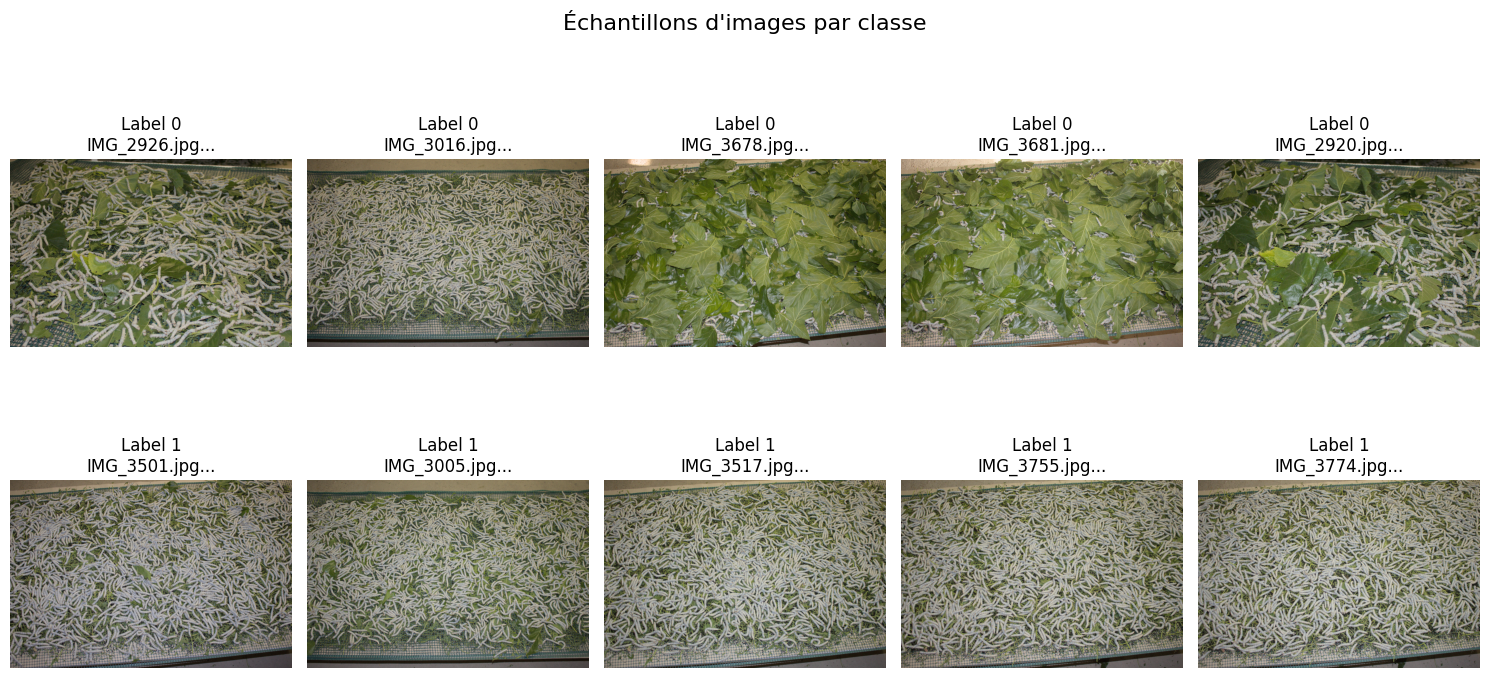

In [ ]:
# 6. Analyser les propriétés des images
def analyze_image_properties():
    """Analyse les dimensions, formats et qualité des images"""

    print("\n🔍 Analyse des propriétés des images:")

    # Échantillonner quelques images pour l'analyse
    sample_size = min(100, len(CLEAN_DF))
    sample_df = CLEAN_DF.sample(n=sample_size, random_state=42)

    dimensions = []
    file_sizes = []
    formats = []

    print(f"📊 Analyse de {sample_size} images échantillonnées...")

    for _, row in sample_df.iterrows():
        filename = str(row[FILENAME_COL])
        image_path = os.path.join(IMAGE_DIR, filename)

        try:
            # Ouvrir l'image avec PIL
            with Image.open(image_path) as img:
                dimensions.append(img.size)  # (width, height)
                formats.append(img.format)

            # Taille du fichier
            file_sizes.append(os.path.getsize(image_path))

        except Exception as e:
            print(f"⚠️ Erreur avec {filename}: {e}")

    if dimensions:
        # Analyser les dimensions
        widths = [d[0] for d in dimensions]
        heights = [d[1] for d in dimensions]

        print(f"\n📏 Dimensions des images:")
        print(f"  - Largeur: min={min(widths)}, max={max(widths)}, moyenne={np.mean(widths):.0f}")
        print(f"  - Hauteur: min={min(heights)}, max={max(heights)}, moyenne={np.mean(heights):.0f}")

        # Dimensions les plus communes
        unique_dims = list(set(dimensions))
        dim_counts = [dimensions.count(d) for d in unique_dims]
        most_common_dim = unique_dims[np.argmax(dim_counts)]
        print(f"  - Dimension la plus commune: {most_common_dim}")

        # Formats
        format_counts = pd.Series(formats).value_counts()
        print(f"\n📄 Formats d'images:")
        for fmt, count in format_counts.items():
            print(f"  - {fmt}: {count} images")

        # Tailles de fichiers
        avg_size_mb = np.mean(file_sizes) / (1024*1024)
        print(f"\n💾 Taille moyenne des fichiers: {avg_size_mb:.2f} MB")

        # Visualiser quelques images
        print(f"\n🖼️ Visualisation d'échantillons par classe:")

        plt.figure(figsize=(15, 8))

        for label in [0, 1]:
            label_df = CLEAN_DF[CLEAN_DF[LABEL_COL] == label].sample(n=min(5, len(CLEAN_DF[CLEAN_DF[LABEL_COL] == label])), random_state=42)

            for i, (_, row) in enumerate(label_df.iterrows()):
                filename = str(row[FILENAME_COL])
                image_path = os.path.join(IMAGE_DIR, filename)

                try:
                    img = Image.open(image_path)
                    plt.subplot(2, 5, label*5 + i + 1)
                    plt.imshow(img)
                    plt.title(f'Label {label}\n{filename[:20]}...')
                    plt.axis('off')
                except:
                    continue

        plt.suptitle('Échantillons d\'images par classe', fontsize=16)
        plt.tight_layout()
        plt.show()

        return {
            'avg_width': np.mean(widths),
            'avg_height': np.mean(heights),
            'most_common_dim': most_common_dim,
            'formats': format_counts.to_dict(),
            'avg_size_mb': avg_size_mb
        }

    return None

# Analyser les images
if 'CLEAN_DF' in globals():
    image_stats = analyze_image_properties()
else:
    print("❌ Exécutez d'abord les cellules précédentes.")

# Data augmentation

# DinoV2 + Classifier Head - Freezed backbone

In [ ]:
# 🔧 VERSION CORRIGÉE ET AMÉLIORÉE du code DINOv2

!pip install -q torch torchvision transformers lightning scikit-learn

import torch
import torch.nn as nn
import lightning as L
from transformers import AutoImageProcessor, AutoModel
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Vérifier la disponibilité GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Utilisation du device: {device}")

# Charger le modèle DINOv2
print("📥 Chargement de DINOv2...")
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
backbone = AutoModel.from_pretrained("facebook/dinov2-base").to(device)

# Figer le backbone
backbone.eval()
for param in backbone.parameters():
    param.requires_grad = False

print(f"✅ DINOv2 chargé - Dimension des embeddings: {backbone.config.hidden_size}")

class DinoClassifier(nn.Module):
    """Classificateur léger au-dessus de DINOv2"""
    def __init__(self, input_dim=768, hidden_dim=256):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 128),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        # x est le CLS token [batch_size, hidden_dim]
        return self.classifier(x)

class LitSilkwormClassifier(L.LightningModule):
    """Module Lightning pour l'entraînement"""
    def __init__(self, learning_rate=1e-4):
        super().__init__()
        self.save_hyperparameters()

        self.backbone = backbone
        self.classifier = DinoClassifier(backbone.config.hidden_size)
        self.criterion = nn.BCEWithLogitsLoss()

        # Pour collecter les prédictions et labels
        self.validation_outputs = []

    def forward(self, images):
        # Préprocesser les images pour DINOv2
        if isinstance(images, list):
            # Si c'est une liste d'images PIL
            inputs = processor(images, return_tensors="pt")
            pixel_values = inputs['pixel_values'].to(self.device)
        else:
            # Si c'est déjà un tensor
            pixel_values = images

        # Extraire les features avec DINOv2
        with torch.no_grad():
            outputs = self.backbone(pixel_values)
            # Prendre le CLS token (premier token)
            features = outputs.last_hidden_state[:, 0]  # [batch_size, hidden_dim]

        # Classification
        logits = self.classifier(features)
        return logits.squeeze(-1)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        loss = self.criterion(logits, labels.float())

        # Calculer l'accuracy
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
        acc = (preds == labels.float()).float().mean()

        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        """Étape de test - identique à validation_step mais pour le test set"""
        images, labels = batch
        logits = self(images)
        loss = self.criterion(logits, labels.float())

        # Calculer les métriques
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
        acc = (preds == labels.float()).float().mean()

        # Log des métriques de test
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)

        return {
            'test_loss': loss,
            'test_acc': acc,
            'preds': preds,
            'labels': labels,
            'probs': probs
        }

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        loss = self.criterion(logits, labels.float())

        # Sauvegarder pour les métriques finales
        probs = torch.sigmoid(logits)
        self.validation_outputs.append({
            'probs': probs.cpu(),
            'labels': labels.cpu(),
            'loss': loss.cpu()
        })

        self.log('val_loss', loss, prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        if self.validation_outputs:
            # Concaténer toutes les prédictions
            all_probs = torch.cat([x['probs'] for x in self.validation_outputs])
            all_labels = torch.cat([x['labels'] for x in self.validation_outputs])

            # Calculer les métriques
            preds = (all_probs > 0.5).float()
            acc = accuracy_score(all_labels.numpy(), preds.numpy())
            f1 = f1_score(all_labels.numpy(), preds.numpy())

            self.log('val_acc', acc, prog_bar=True)
            self.log('val_f1', f1, prog_bar=True)

            # Vider pour la prochaine époque
            self.validation_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.classifier.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=0.01
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=20, eta_min=1e-6
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
        }

print("✅ Modèle défini!")

🔥 Utilisation du device: cuda
📥 Chargement de DINOv2...
✅ DINOv2 chargé - Dimension des embeddings: 768
✅ Modèle défini!


In [ ]:
# HYPERPARAMETRES - MODIFIER ICI
BATCH_SIZE = 32
LEARNING_RATE = 2e-4
WEIGHT_DECAY = 0.01
MAX_EPOCHS = 15
NUM_WORKERS = 2
DROPOUT_RATE = 0.2
PATIENCE = 5

# Transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets
train_dataset = datasets.ImageFolder("/content/organized_dataset/train", transform=train_transforms)
val_dataset = datasets.ImageFolder("/content/organized_dataset/val", transform=val_transforms)
test_dataset = datasets.ImageFolder("/content/organized_dataset/test", transform=val_transforms)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Modèle
model = LitSilkwormClassifier(learning_rate=LEARNING_RATE)

# Callbacks
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor="val_loss", patience=PATIENCE, mode="min"),
    ModelCheckpoint(monitor="val_f1", mode="max", save_top_k=1, filename="best_model")
]

# Trainer
trainer = L.Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator="gpu",
    devices=1,
    precision="16-mixed",
    callbacks=callbacks,
    logger=False
)

# Entraînement
print("🚀 Démarrage entraînement...")
trainer.fit(model, train_loader, val_loader)

# Test final
print("📊 Test final...")
test_results = trainer.test(model, test_loader)
print(f"Test accuracy: {test_results[0]['test_acc']:.4f}")
print("✅ Terminé!")

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:658: Checkpoint directory /content/checkpoints exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | backbone   | Dinov2Model       | 86.6 M | eval 
1 | classifier | DinoCla

🚀 Démarrage entraînement...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=15` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


📊 Test final...


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9485294222831726     │
│         test_loss         │    0.1399063616991043     │
└───────────────────────────┴───────────────────────────┘

Test accuracy: 0.9485
✅ Terminé!


🚀 Lancement de l'évaluation complète...
🔍 Évaluation complète du modèle...

📈 MÉTRIQUES DÉTAILLÉES
              precision    recall  f1-score   support

    Classe 0     0.9206    0.9667    0.9431        60
    Classe 1     0.9726    0.9342    0.9530        76

    accuracy                         0.9485       136
   macro avg     0.9466    0.9504    0.9481       136
weighted avg     0.9497    0.9485    0.9486       136


❌ Nombre d'erreurs: 7 sur 136 (5.1%)


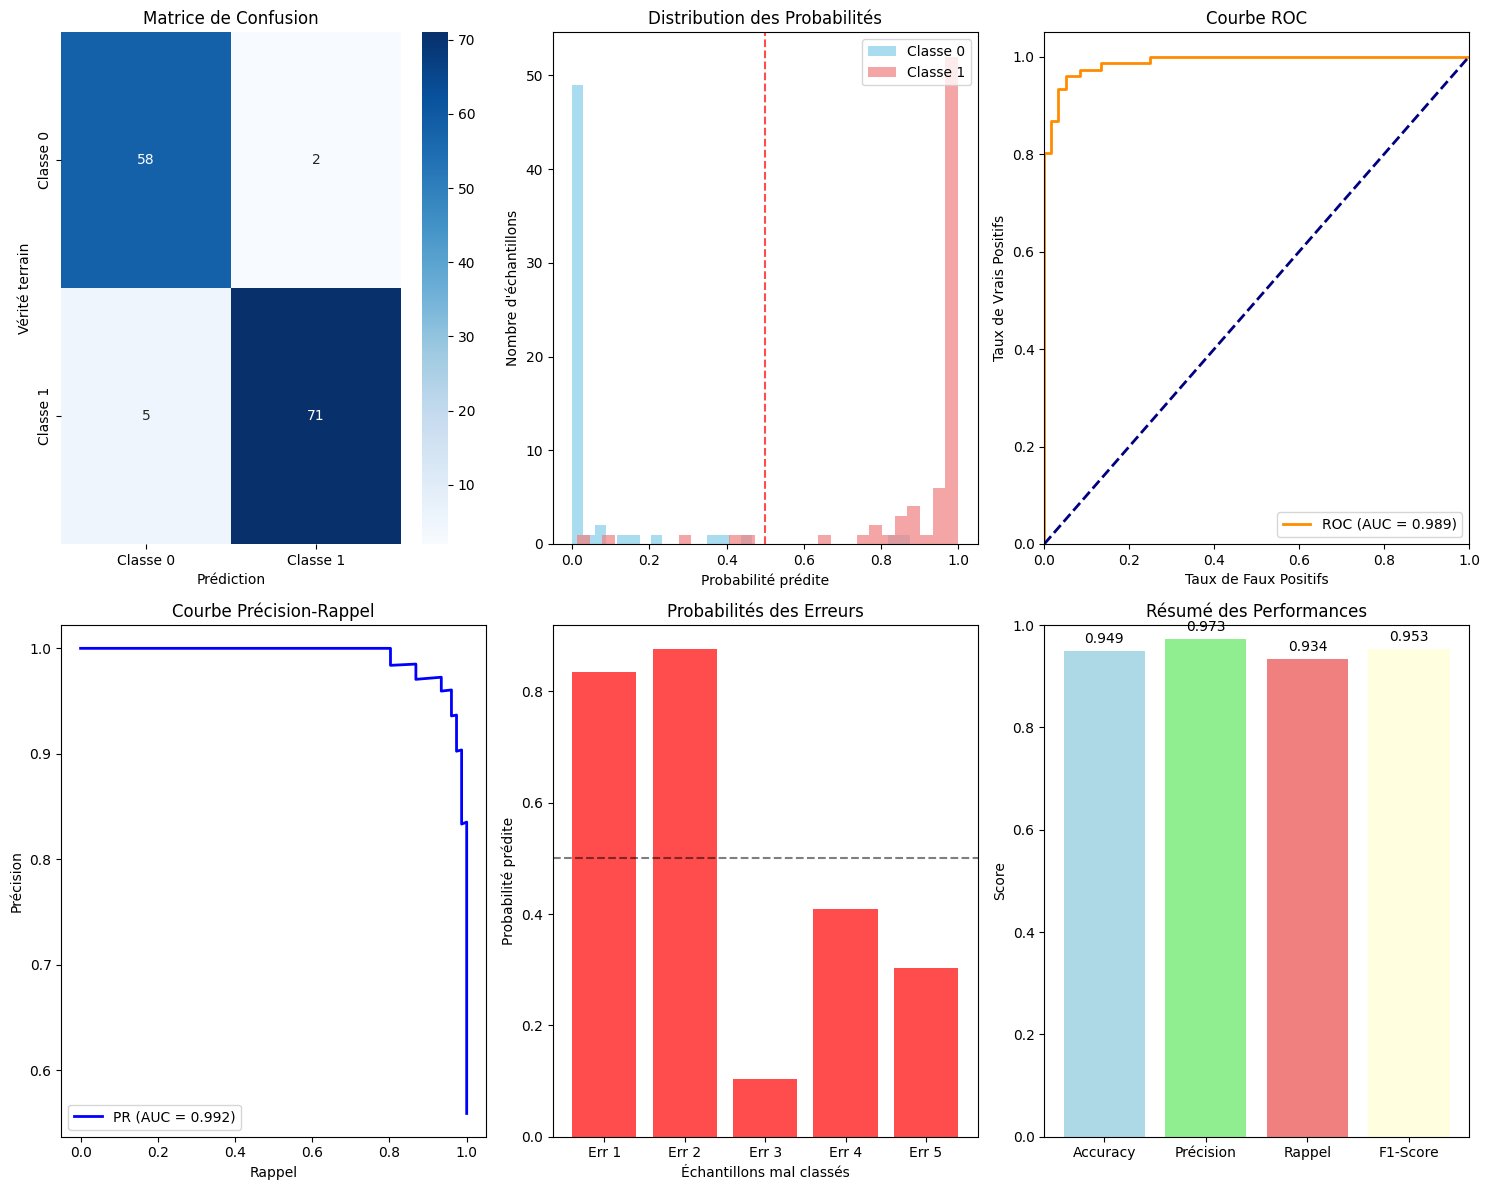


🎯 RÉSUMÉ FINAL
✅ Accuracy: 0.9485
📊 Précision: 0.9726
🔍 Rappel: 0.9342
⚖️ F1-Score: 0.9530
📈 ROC-AUC: 0.9893
📉 PR-AUC: 0.9918
❌ Erreurs: 7/136

🎉 Évaluation terminée!


In [ ]:
# 📊 ÉVALUATION COMPLÈTE DU MODÈLE
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os

def evaluate_model_complete(model, test_loader, trainer):
    """Évaluation complète du modèle avec visualisations"""

    print("🔍 Évaluation complète du modèle...")

    # 1. Collecter toutes les prédictions
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch
            logits = model(images)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # 2. Métriques détaillées
    print("\n📈 MÉTRIQUES DÉTAILLÉES")
    print("=" * 50)
    print(classification_report(all_labels, all_preds,
                               target_names=['Classe 0', 'Classe 1'],
                               digits=4))

    # 3. Matrice de confusion
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(15, 12))

    # Matrice de confusion
    plt.subplot(2, 3, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Classe 0', 'Classe 1'],
                yticklabels=['Classe 0', 'Classe 1'])
    plt.title('Matrice de Confusion')
    plt.xlabel('Prédiction')
    plt.ylabel('Vérité terrain')

    # 4. Distribution des probabilités
    plt.subplot(2, 3, 2)
    plt.hist(all_probs[all_labels == 0], bins=30, alpha=0.7, label='Classe 0', color='skyblue')
    plt.hist(all_probs[all_labels == 1], bins=30, alpha=0.7, label='Classe 1', color='lightcoral')
    plt.xlabel('Probabilité prédite')
    plt.ylabel('Nombre d\'échantillons')
    plt.title('Distribution des Probabilités')
    plt.legend()
    plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.7)

    # 5. Courbe ROC
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.subplot(2, 3, 3)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de Faux Positifs')
    plt.ylabel('Taux de Vrais Positifs')
    plt.title('Courbe ROC')
    plt.legend()

    # 6. Courbe Précision-Rappel
    precision, recall, _ = precision_recall_curve(all_labels, all_probs)
    pr_auc = auc(recall, precision)

    plt.subplot(2, 3, 4)
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR (AUC = {pr_auc:.3f})')
    plt.xlabel('Rappel')
    plt.ylabel('Précision')
    plt.title('Courbe Précision-Rappel')
    plt.legend()

    # 7. Analyse des erreurs - Échantillons mal classés
    wrong_indices = np.where(all_preds != all_labels)[0]
    print(f"\n❌ Nombre d'erreurs: {len(wrong_indices)} sur {len(all_labels)} ({len(wrong_indices)/len(all_labels)*100:.1f}%)")

    if len(wrong_indices) > 0:
        # Visualiser quelques échantillons mal classés
        plt.subplot(2, 3, 5)

        # Prendre les 5 premières erreurs
        sample_errors = wrong_indices[:min(5, len(wrong_indices))]

        # Créer un graphique des probabilités des erreurs
        error_probs = all_probs[sample_errors]
        error_labels = all_labels[sample_errors]
        error_preds = all_preds[sample_errors]

        x_pos = np.arange(len(sample_errors))
        colors = ['red' if pred != label else 'green' for pred, label in zip(error_preds, error_labels)]

        plt.bar(x_pos, error_probs, color=colors, alpha=0.7)
        plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
        plt.xlabel('Échantillons mal classés')
        plt.ylabel('Probabilité prédite')
        plt.title('Probabilités des Erreurs')
        plt.xticks(x_pos, [f'Err {i+1}' for i in range(len(sample_errors))])

    # 8. Résumé des performances
    plt.subplot(2, 3, 6)

    # Calculer les métriques finales
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    metrics = ['Accuracy', 'Précision', 'Rappel', 'F1-Score']
    values = [accuracy, precision, recall, f1]

    bars = plt.bar(metrics, values, color=['lightblue', 'lightgreen', 'lightcoral', 'lightyellow'])
    plt.ylim(0, 1)
    plt.title('Résumé des Performances')
    plt.ylabel('Score')

    # Ajouter les valeurs sur les barres
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # 9. Résumé textuel
    print(f"\n🎯 RÉSUMÉ FINAL")
    print("=" * 50)
    print(f"✅ Accuracy: {accuracy:.4f}")
    print(f"📊 Précision: {precision:.4f}")
    print(f"🔍 Rappel: {recall:.4f}")
    print(f"⚖️ F1-Score: {f1:.4f}")
    print(f"📈 ROC-AUC: {roc_auc:.4f}")
    print(f"📉 PR-AUC: {pr_auc:.4f}")
    print(f"❌ Erreurs: {len(wrong_indices)}/{len(all_labels)}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'confusion_matrix': cm,
        'wrong_predictions': len(wrong_indices)
    }

# Lancer l'évaluation complète
print("🚀 Lancement de l'évaluation complète...")
eval_results = evaluate_model_complete(model, test_loader, trainer)

print("\n🎉 Évaluation terminée!")

## Sauvegarde du modèle

In [ ]:
# 💾 SAUVEGARDE COMPLÈTE DU MODÈLE DANS GOOGLE DRIVE
import os
import json
import datetime
import shutil
from google.colab import drive

def save_model_to_drive(model, trainer, eval_results, hyperparams=None):
    """Sauvegarde complète du modèle dans Google Drive"""

    print("💾 Sauvegarde du modèle dans Google Drive...")

    # 1. Créer un dossier avec timestamp
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    model_name = f"silkworm_dinov2_{timestamp}"
    save_dir = f"/content/drive/MyDrive/Models/{model_name}"

    # Créer le dossier
    os.makedirs(save_dir, exist_ok=True)
    print(f"📁 Dossier créé : {save_dir}")

    # 2. Sauvegarder le modèle Lightning
    model_path = f"{save_dir}/model.ckpt"
    trainer.save_checkpoint(model_path)
    print(f"✅ Modèle sauvegardé : model.ckpt")

    # 3. Sauvegarder les hyperparamètres
    if hyperparams is None:
        hyperparams = {
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'max_epochs': MAX_EPOCHS,
            'dropout_rate': DROPOUT_RATE,
            'patience': PATIENCE,
            'weight_decay': WEIGHT_DECAY,
            'model_type': 'dinov2-base + classifier',
            'timestamp': timestamp
        }

    # Ajouter les résultats d'évaluation (convertir numpy en types Python)
    eval_results_json = {
        'accuracy': float(eval_results['accuracy']),
        'precision': float(eval_results['precision']),
        'recall': float(eval_results['recall']),
        'f1': float(eval_results['f1']),
        'roc_auc': float(eval_results['roc_auc']),
        'pr_auc': float(eval_results['pr_auc']),
        'wrong_predictions': int(eval_results['wrong_predictions']),
        'confusion_matrix': eval_results['confusion_matrix'].tolist()  # Convertir numpy array en liste
    }

    hyperparams.update({
        'final_results': eval_results_json,
        'training_completed': True
    })

    hyperparams_path = f"{save_dir}/hyperparams.json"
    with open(hyperparams_path, 'w') as f:
        json.dump(hyperparams, f, indent=2)
    print(f"✅ Hyperparamètres sauvegardés : hyperparams.json")

    # 4. Sauvegarder les poids du classificateur seulement (plus léger)
    classifier_path = f"{save_dir}/classifier_weights.pth"
    torch.save(model.classifier.state_dict(), classifier_path)
    print(f"✅ Poids du classificateur : classifier_weights.pth")

    # 5. Créer un fichier README avec les instructions
    readme_content = f"""# Silkworm Classification Model - {timestamp}

## Résultats
- Accuracy: {eval_results['accuracy']:.4f}
- F1-Score: {eval_results['f1']:.4f}
- Précision: {eval_results['precision']:.4f}
- Rappel: {eval_results['recall']:.4f}

## Fichiers
- `model.ckpt`: Modèle Lightning complet
- `classifier_weights.pth`: Poids du classificateur seulement
- `hyperparams.json`: Hyperparamètres et résultats
- `README.md`: Ce fichier

## Rechargement
```python
# Recharger le modèle complet
model = LitSilkwormClassifier.load_from_checkpoint("model.ckpt")

# Ou recharger seulement le classificateur
model = LitSilkwormClassifier()
model.classifier.load_state_dict(torch.load("classifier_weights.pth"))
```

## Utilisation
```python
# Prédiction sur une nouvelle image
model.eval()
with torch.no_grad():
    prediction = model(image_tensor)
    probability = torch.sigmoid(prediction)
```
"""

    readme_path = f"{save_dir}/README.md"
    with open(readme_path, 'w') as f:
        f.write(readme_content)
    print(f"✅ Instructions sauvegardées : README.md")

    # 6. Calculer les tailles de fichiers
    total_size = 0
    for file in os.listdir(save_dir):
        file_path = os.path.join(save_dir, file)
        size = os.path.getsize(file_path)
        total_size += size
        print(f"📄 {file}: {size/1024/1024:.2f} MB")

    print(f"\n📊 Taille totale: {total_size/1024/1024:.2f} MB")

    # 7. Créer un lien de sauvegarde rapide pour la prochaine fois
    latest_link = "/content/drive/MyDrive/Models/latest_silkworm_model"
    if os.path.exists(latest_link):
        os.remove(latest_link)
    os.symlink(save_dir, latest_link)
    print(f"🔗 Lien 'latest' créé pour accès rapide")

    return save_dir

# Lancer la sauvegarde
save_dir = save_model_to_drive(model, trainer, eval_results)

print(f"\n🎉 Sauvegarde terminée!")
print(f"📁 Emplacement: {save_dir}")
print(f"💡 Accès rapide: /content/drive/MyDrive/Models/latest_silkworm_model")

💾 Sauvegarde du modèle dans Google Drive...
📁 Dossier créé : /content/drive/MyDrive/Models/silkworm_dinov2_20250709_083337
✅ Modèle sauvegardé : model.ckpt
✅ Hyperparamètres sauvegardés : hyperparams.json
✅ Poids du classificateur : classifier_weights.pth
✅ Instructions sauvegardées : README.md
📄 model.ckpt: 333.00 MB
📄 hyperparams.json: 0.00 MB
📄 classifier_weights.pth: 0.88 MB
📄 README.md: 0.00 MB

📊 Taille totale: 333.88 MB
🔗 Lien 'latest' créé pour accès rapide

🎉 Sauvegarde terminée!
📁 Emplacement: /content/drive/MyDrive/Models/silkworm_dinov2_20250709_083337
💡 Accès rapide: /content/drive/MyDrive/Models/latest_silkworm_model


In [ ]:
# 🔄 RECHARGEMENT DU MODÈLE SAUVEGARDÉ
def load_model_from_drive(model_path=None):
    """Recharge un modèle depuis Google Drive"""

    if model_path is None:
        # Utiliser le lien 'latest' par défaut
        model_path = "/content/drive/MyDrive/Models/latest_silkworm_model"

    print(f"📥 Rechargement du modèle depuis : {model_path}")

    # Vérifier l'existence
    if not os.path.exists(model_path):
        print("❌ Modèle non trouvé!")
        return None

    # Charger les hyperparamètres
    hyperparams_path = f"{model_path}/hyperparams.json"
    if os.path.exists(hyperparams_path):
        with open(hyperparams_path, 'r') as f:
            hyperparams = json.load(f)
        print("✅ Hyperparamètres chargés")
        print(f"   - Accuracy: {hyperparams['final_results']['accuracy']:.4f}")
        print(f"   - F1-Score: {hyperparams['final_results']['f1']:.4f}")

    # Charger le modèle complet
    model_checkpoint = f"{model_path}/model.ckpt"
    if os.path.exists(model_checkpoint):
        model = LitSilkwormClassifier.load_from_checkpoint(model_checkpoint)
        print("✅ Modèle Lightning chargé")
        return model
    else:
        print("❌ Fichier model.ckpt non trouvé")
        return None

# Fonction pour prédire sur une nouvelle image
def predict_silkworm_image(model, image_path):
    """Prédiction sur une nouvelle image"""

    # Charger et préprocesser l'image
    from PIL import Image
    image = Image.open(image_path).convert('RGB')

    # Appliquer les transformations de validation
    image_tensor = val_transforms(image).unsqueeze(0)  # Ajouter batch dimension

    # Prédiction
    model.eval()
    with torch.no_grad():
        logits = model(image_tensor)
        probability = torch.sigmoid(logits).item()
        prediction = int(probability > 0.5)  # Convertir booléen en entier

    return {
        'prediction': prediction,
        'probability': probability,
        'confidence': abs(probability - 0.5) * 2  # Confidence normalisée 0-1
    }

In [ ]:
# Exemple d'utilisation


model_path = "/content/drive/MyDrive/Models/silkworm_dinov2_20250709_074454"
img_path = "/content/organized_dataset/test/class_0/IMG_2664.jpg"

model_reloaded = load_model_from_drive(model_path)

if model_reloaded:
    result = predict_silkworm_image(model_reloaded, img_path)
    print(f"Prédiction: {result['prediction']}")
    print(f"Probabilité: {result['probability']:.3f}")
    print(f"Confiance: {result['confidence']:.3f}")

print("✅ Fonctions de rechargement prêtes!")

📥 Rechargement du modèle depuis : /content/drive/MyDrive/Models/silkworm_dinov2_20250709_074454
✅ Hyperparamètres chargés
   - Accuracy: 0.9191
   - F1-Score: 0.9252
✅ Modèle Lightning chargé
Prédiction: 0
Probabilité: 0.005
Confiance: 0.990
✅ Fonctions de rechargement prêtes!
